# 1. Problem Introduction

Hey there! In this project, I'm diving into the cool world of sketch recognition, inspired by Google's QuickDraw game. My aim is to build a sketch classification model that can accurately identify animal categories from this dataset. To make this happen, I'll be using popular tools like numpy, TensorFlow, scikit-learn, and pandas.

The dataset I'll be using is the The QuickDraw dataset (https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/simplified). It's a treasure trove of simplified drawings collected through the online game, "Quick, Draw!". It's a fantastic resource for training machine learning models that can recognize and classify sketches.

I've broken down the project into five parts, all in a Jupyter Notebook:
1. **Problem Introduction**: You're reading it! Introducing the problem and tools I'll use.
2. **Proposed Solution**: I'll outline my approach, including the model architecture, pre-processing, and optimization techniques.
3. **Experimental Setup**: I'll discuss how I get the data, create my dataset, and evaluate my model.
4. **Results**: I'll showcase how well my model did with stats, figures, and plots.
5. **Conclusion**: I'll wrap up, talk about what my work means, and suggest future improvements.

By following this plan, I hope to create a powerful sketch classification model that's easy to understand and can help push the boundaries of sketch recognition! (not really)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Proposed Solution

Great! Now that we have a clear understanding of the problem, let's dive into our proposed solution. We'll outline the main components, such as using the dataset, building our neural network with TensorFlow, and selecting appropriate activation functions.

## Dataset
The QuickDraw dataset is available at https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/simplified. It contains numerous `.ndjson` files, each representing a category of doodles. Since we're focusing on animal categories, we'll handpick a few of these files (e.g., 'cat.ndjson', 'dog.ndjson', 'elephant.ndjson', etc.) and download them to our project directory.

To load and integrate the dataset into our project, we'll use Python's `json` library to parse the `.ndjson` files, and pandas to store the data in a structured format. We'll preprocess the data by normalizing the sketches, resizing them to a standard size, and converting them into NumPy arrays for further processing.

## Neural Network Architecture
We'll use TensorFlow to build our neural network, which will be a Convolutional Neural Network (CNN) due to its excellent performance in image recognition tasks. Here's a high-level overview of the architecture:

1. Input Layer: Takes in the preprocessed sketches as input.
2. Convolutional Layer 1: Applies a set of filters to the input to capture local patterns in the images. We'll use the ReLU activation function for its non-linear properties and ability to mitigate the vanishing gradient problem.
3. Pooling Layer 1: Reduces the spatial dimensions of the convolutional layer's output using max-pooling.
4. Convolutional Layer 2: Applies another set of filters to capture more complex patterns. We'll use the ReLU activation function again.
5. Pooling Layer 2: Further reduces the spatial dimensions using max-pooling.
6. Flatten Layer: Flattens the output of the previous layer into a one-dimensional vector.
7. Fully Connected Layer (Dense): A fully connected layer to learn global patterns in the data. We'll use the ReLU activation function.
8. Output Layer: Produces the final classification probabilities for each animal category using the softmax activation function.

This architecture provides a good balance between complexity and performance. However, feel free to experiment with the number of layers, filters, and other hyperparameters to find the optimal configuration for our task.

## Training and Evaluation
We'll split our dataset into training and validation sets to monitor the model's performance during training. We'll use categorical cross-entropy as our loss function since it's suitable for multi-class classification problems. To optimize the model, we'll use the Adam optimizer, which is a popular choice for its adaptability and efficiency.

We'll train our model for several epochs while monitoring the validation accuracy and loss. To prevent overfitting, we can implement early stopping or dropout layers in our network. Finally, we'll visualize the training progress with plots and evaluate the model's performance on a separate test set.

With this proposed solution, we aim to build an efficient sketch classification model that can accurately identify animal categories from the QuickDraw dataset. Let's move forward with the experimental setup and bring our solution to life!

# 3. Experimental Setup

### Data Loading and Preprocessing

First, let's load the animal dataset files from the `/data` directory. We'll use the `ndjson` library to read the `.ndjson` files, and pandas to store the data in a structured format.

In [2]:
!pip install ndjson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
# import json
import ndjson
import pandas as pd
import numpy as np
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


data_dir = "/content/drive/MyDrive/CS-490/sketch-classifier-DL/data"
# categories = ["ant", "bear", "cat", "dog", "elephant"]  # Add or modify the list to include the animal categories you've downloaded
categories = ["ant", "bat", "bear", "bee", "bird"] 
data = []
examples_per_category = 2500

for category in categories:
    file_path = os.path.join(data_dir, f"full_simplified_{category}.ndjson")
    with open(file_path) as f:
        drawings = ndjson.load(f)
        for i, drawing in enumerate(drawings):
            if i >= examples_per_category:
                break
            data.append({"category": category, "drawing": drawing["drawing"]})

data_df = pd.DataFrame(data)


In [4]:
import tensorflow as tf

Now, let's preprocess the data by normalizing the sketches, resizing them to a standard size, and converting them into NumPy arrays. We'll use the `cv2` library to help us with the resizing process.

In [5]:
import cv2

def drawing_to_np_array(drawing, img_size=256):
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    
    for stroke in drawing:
        stroke_coords = np.array(stroke).T
        for i in range(len(stroke_coords) - 1):
            x0, y0 = stroke_coords[i]
            x1, y1 = stroke_coords[i + 1]
            img = cv2.line(img, (x0, y0), (x1, y1), 255, 2)
    
    return img

data_df["img"] = data_df["drawing"].apply(lambda x: drawing_to_np_array(x))

Next, let's split the dataset into training, validation, and testing sets, and convert the labels into one-hot encoded format using scikit-learn's `LabelBinarizer`.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

X = np.stack(data_df["img"].values, axis=0)
X = X.reshape(X.shape[0], 256, 256, 1)  # Add a channel dimension
# X = X / 255.0  # Normalize pixel values

y = data_df["category"].values
lb = LabelBinarizer()
y = lb.fit_transform(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Data augmentation to add more training examples in an attempt to reduce overfitting

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation settings
augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for the training set
train_generator = augmentation.flow(
    X_train, y_train, batch_size=64
)

# Create a generator for the validation set (without augmentation)
val_generator = ImageDataGenerator().flow(
    X_val, y_val, batch_size=64
)


### Building the CNN Model

Now that our data is prepared, let's build the CNN model using TensorFlow.

In [8]:
from tensorflow.keras.regularizers import l2

In [9]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(256, 256, 1)),
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(len(categories), activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(256, 256, 1)),
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D((2, 2)),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(len(categories), activation='softmax')
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 1)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Add L2 regularization here
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


### Training the Model

Now, let's train our model using the training and validation datasets.

In [10]:
epochs = 10  # Adjust the number of epochs as needed
batch_size = 64

# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_data=(X_val, y_val)
# )

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)


Epoch 1/10
136/136 [==============================] - 60s 339ms/step - loss: 4.2126 - accuracy: 0.3374 - val_loss: 1.7070 - val_accuracy: 0.4709
Epoch 2/10
136/136 [==============================] - 45s 332ms/step - loss: 1.7252 - accuracy: 0.4419 - val_loss: 1.4949 - val_accuracy: 0.5523
Epoch 3/10
136/136 [==============================] - 45s 334ms/step - loss: 1.5951 - accuracy: 0.4916 - val_loss: 1.3612 - val_accuracy: 0.5986
Epoch 4/10
136/136 [==============================] - 44s 325ms/step - loss: 1.5247 - accuracy: 0.5056 - val_loss: 1.3723 - val_accuracy: 0.5900
Epoch 5/10
136/136 [==============================] - 44s 325ms/step - loss: 1.4200 - accuracy: 0.5571 - val_loss: 1.2473 - val_accuracy: 0.6584
Epoch 6/10
136/136 [==============================] - 45s 328ms/step - loss: 1.3283 - accuracy: 0.6028 - val_loss: 1.1289 - val_accuracy: 0.7096
Epoch 7/10
136/136 [==============================] - 46s 336ms/step - loss: 1.2429 - accuracy: 0.6363 - val_loss: 1.1322 - val_ac

### Evaluation Procedure

After training the model, let's evaluate its performance on the test dataset.

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

59/59 [==============================] - 2s 17ms/step - loss: 1.1329 - accuracy: 0.7003
Test Loss: 1.1329, Test Accuracy: 0.7003


Finally, we can visualize the training progress by plotting the training and validation accuracy and loss over time.

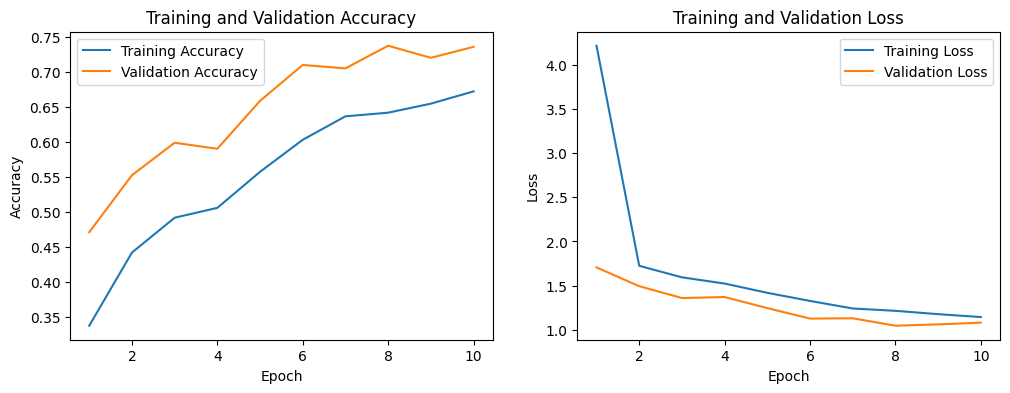

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
epochs_range = range(1, epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label="Training Accuracy")
plt.plot(epochs_range, history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label="Training Loss")
plt.plot(epochs_range, history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.show()

This concludes the experimental setup and evaluation procedure for our sketch classification model. Depending on the performance, you can further fine-tune the model, adjust hyperparameters, or add more animal categories for a more comprehensive classifier.